In [2]:
import os
print("Current directory:", os.getcwd())
#just checking where Im at ;-;

Current directory: c:\Users\Hawaii\Documents\GitHub\Team-2\Mikaylas_Folder


# 🔋 Assignment 3: Building Load & PV Analysis

Analyze building energy data using main meter and PV generation readings. Specifically Life Science Building. 
We merge both data sources to compute the **net energy consumption**, and use **area under the curve (AUC)** to identify peak energy usage days.  
This helps inform future decisions in energy storage and battery optimization.


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
# If needed, install tabulate first
!pip install tabulate

# Import libraries
import pandas as pd
from tabulate import tabulate



## 📥 Step 1: Load Meter & PV Data

Two datasets to analyze:
- **Load Data:** Represents energy consumed by the building
- **PV Data:** Represents solar energy generated

Both datasets are time-series and will be merged based on timestamps.


In [53]:
# Load the PV and Load data (make sure the files are in your folder)
# Load CSV file
pv_csv_path = 'life_science_pv.csv'  # ← update path to match your folder
pv_df= pd.read_csv(pv_csv_path)
load_csv_path = 'life_sciences_msb1_main.csv'
load_df = pd.read_csv(load_csv_path)
# Preview top 5 rows using tabulate
print(tabulate(load_df.head(), headers='keys', tablefmt='grid'))
print(tabulate(pv_df.head(), headers='keys', tablefmt='grid'))
#should print out a table that hopefully checks out ;-;

+----+---------------------+-------------------------+---------+
|    | datetime            | meter_name              |    mean |
+====+=====================+=========================+=========+
|  0 | 2024-02-01 08:45:00 | life_sciences_msb1_main | 363.724 |
+----+---------------------+-------------------------+---------+
|  1 | 2024-02-03 16:45:00 | life_sciences_msb1_main | 257.679 |
+----+---------------------+-------------------------+---------+
|  2 | 2024-02-06 21:45:00 | life_sciences_msb1_main | 302.49  |
+----+---------------------+-------------------------+---------+
|  3 | 2024-02-17 06:15:00 | life_sciences_msb1_main | 194.196 |
+----+---------------------+-------------------------+---------+
|  4 | 2024-02-19 16:15:00 | life_sciences_msb1_main | 290.544 |
+----+---------------------+-------------------------+---------+
+----+---------------------+-------------+----------------+
|    | datetime            |   sensor_id |   power_avg_kw |
+====+=====================+=======

# 📊 **PV Production Plot** 🌞

This section of the code visualizes the **solar energy (PV production)** over time. 
**I ran into soooo much errors!!!!! Please read through markdowns!(Future Mikayla or Others who aint me)**

Here's what was done:
### 1. **Data Preprocessing**:
- **Converted the timestamp** column (`datetime`) to the proper datetime format.
- **Sorted the data** by date to ensure that the plot is in chronological order.

### 2. **Data Smoothing**:
- Applied a **rolling average** to smooth out the jagged fluctuations in the data using a window size of **5**. This step reduces noise and makes the graph more readable.

### 3. **Graph Customization**:
- The graph was **plotted with a gold line** to represent the **PV production (kW)** over time.
- **X-axis labels (dates)** were spaced out to prevent overlap using `freq='2W'`, which shows one label every **2 weeks**.
- **Figure size** was increased to **14x6 inches** for more breathing room.
- Applied **rotation to the x-tick labels** (45°) to improve readability.

### 4. **Final Output**:
- The result is a **smoothed, spaced-out plot** showing the trends in solar energy production over time.

---


Index(['datetime', 'sensor_id', 'power_avg_kw', 'smoothed_power'], dtype='object')
datetime          0
sensor_id         0
power_avg_kw      0
smoothed_power    4
dtype: int64


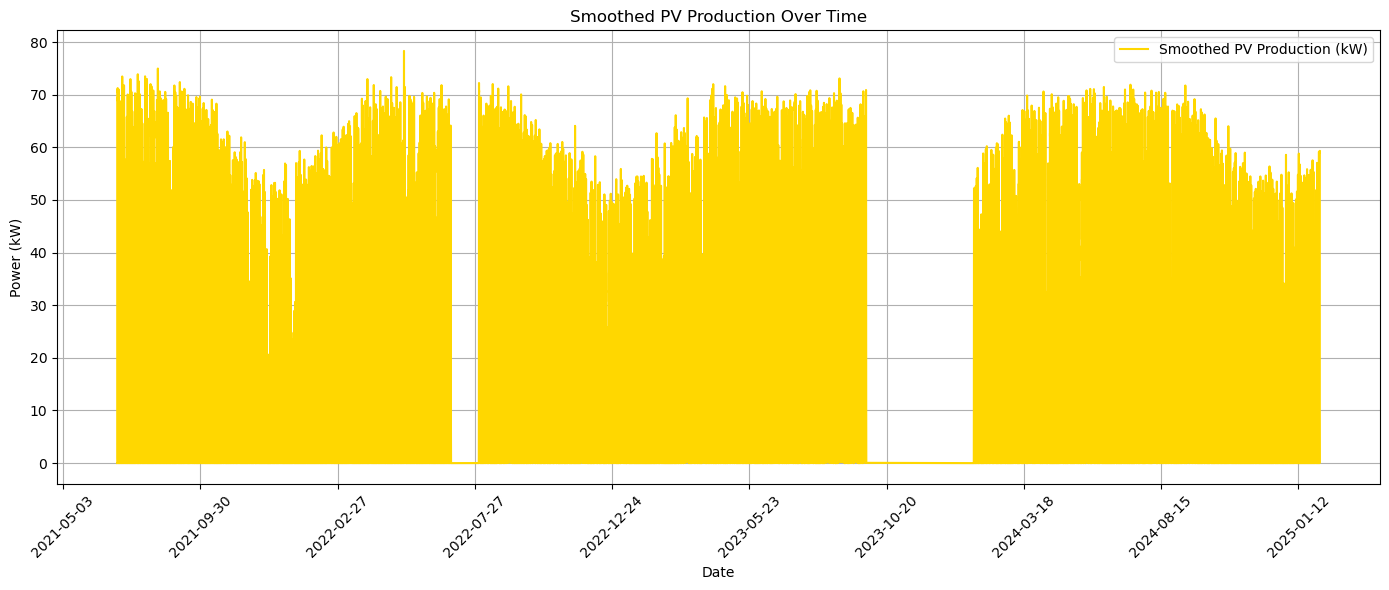

In [69]:
print(pv_df.columns)
# Convert timestamps to datetime (already done, but just in case)
pv_df['datetime'] = pd.to_datetime(pv_df['datetime'])
#DATA DOESNT LOOK CORRECT, HOPEFULLY THIS FIXES IT VVVV
# Check for missing data
print(pv_df.isna().sum())  # Tells you how many NaNs are in each column

# Plot PV production
# Sort data by datetime
pv_df['datetime'] = pd.to_datetime(pv_df['datetime'])
pv_df = pv_df.sort_values(by='datetime')

# Apply a rolling average (smooths out the jaggedness)
window_size = 5
pv_df['smoothed_power'] = pv_df['power_avg_kw'].rolling(window=window_size).mean()

# Increase figure size for more room
plt.figure(figsize=(14, 6))

# Plot the smoothed data
plt.plot(pv_df['datetime'], pv_df['smoothed_power'], color='gold', label='Smoothed PV Production (kW)')

# Adjust x-ticks to prevent overlap (show one tick every 2 weeks)
plt.xticks(
    pd.date_range(start=pv_df['datetime'].min(), end=pv_df['datetime'].max(), freq='2W'),  # Change to '2W' for every 2 weeks
    rotation=45
)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both')) 
# Add labels and title
plt.title("Smoothed PV Production Over Time")
plt.xlabel("Date")
plt.ylabel("Power (kW)")

# Show grid and legend
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


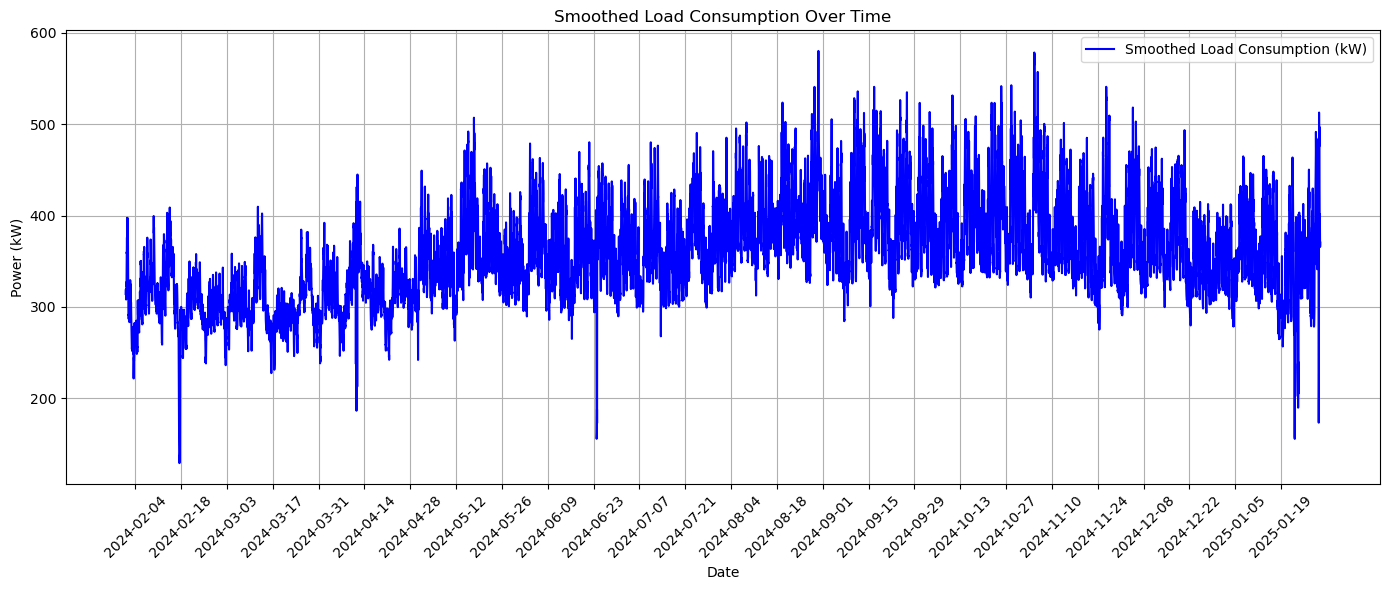

In [71]:
# Convert 'datetime' to proper datetime format for load data (in case it's not already)
load_df['datetime'] = pd.to_datetime(load_df['datetime'])

# Sort load data by datetime
load_df = load_df.sort_values(by='datetime')

# Apply a rolling average (smooth out the jagged fluctuations)
window_size = 5  # Adjust window size if needed
load_df['smoothed_load'] = load_df['mean'].rolling(window=window_size).mean()

# Plot the smoothed load data
plt.figure(figsize=(14, 6))  # Increase the figure size for more room

# Plot the smoothed load data
plt.plot(load_df['datetime'], load_df['smoothed_load'], color='blue', label='Smoothed Load Consumption (kW)')

# Adjust x-ticks to prevent overlap (show one tick every 2 weeks, same as we did for PV)
plt.xticks(
    pd.date_range(start=load_df['datetime'].min(), end=load_df['datetime'].max(), freq='2W'),  # Change to '2W' for every 2 weeks
    rotation=45
)

# Add labels and title
plt.title("Smoothed Load Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Power (kW)")

# Show grid and legend
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## 🔗 Step 2: Merge Data and Calculate Net Load

Now, merge load and PV data on `datetime` and create a new column:

> `net_load = load_kw - pv_kw`

This gives us the net energy drawn from the grid after accounting for PV generation.


In [8]:
#first checking a few things since errors love meee ;/
print("LOAD DF COLUMNS:", load_df.columns)
print("PV DF COLUMNS:", pv_df.columns)


LOAD DF COLUMNS: Index(['datetime', 'meter_name', 'mean'], dtype='object')
PV DF COLUMNS: Index(['datetime', 'sensor_id', 'power_avg_kw'], dtype='object')


In [9]:
def merge_data(load_df, pv_df):
    # Convert datetime columns to datetime dtype
    load_df['datetime'] = pd.to_datetime(load_df['datetime'])
    pv_df['datetime'] = pd.to_datetime(pv_df['datetime'])

    # Rename columns for clarity
    load_df = load_df.rename(columns={'mean': 'load_kw'})
    pv_df = pv_df.rename(columns={'power_avg_kw': 'pv_kw'})

    # Merge on datetime using an inner join
    merged_df = pd.merge(load_df, pv_df, on='datetime', how='inner')

    # Calculate net load: load - PV
    merged_df['net_load_kw'] = merged_df['load_kw'] - merged_df['pv_kw']

    return merged_df

merged_df = merge_data(load_df, pv_df)
merged_df.head()


,datetime,meter_name,load_kw,sensor_id,pv_kw,net_load_kw
0,2024-02-01 08:45:00,life_sciences_msb1_main,363.723543,6,11.764334,351.959209
1,2024-02-03 16:45:00,life_sciences_msb1_main,257.678535,6,18.689332,238.989203
2,2024-02-19 16:15:00,life_sciences_msb1_main,290.543830,6,25.568666,264.975164
3,2024-02-22 11:00:00,life_sciences_msb1_main,322.671190,6,53.838664,268.832526
4,2024-02-26 11:15:00,life_sciences_msb1_main,334.333700,6,36.713664,297.620036


C:\Users\Hawaii\AppData\Local\Temp\ipykernel_28192\2551376278.py:45: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  pv_timestamps = pv_df['datetime'].view('int64') // 10**9  # Convert to seconds
C:\Users\Hawaii\AppData\Local\Temp\ipykernel_28192\2551376278.py:46: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  load_timestamps = load_df['datetime'].view('int64') // 10**9  # Convert to seconds


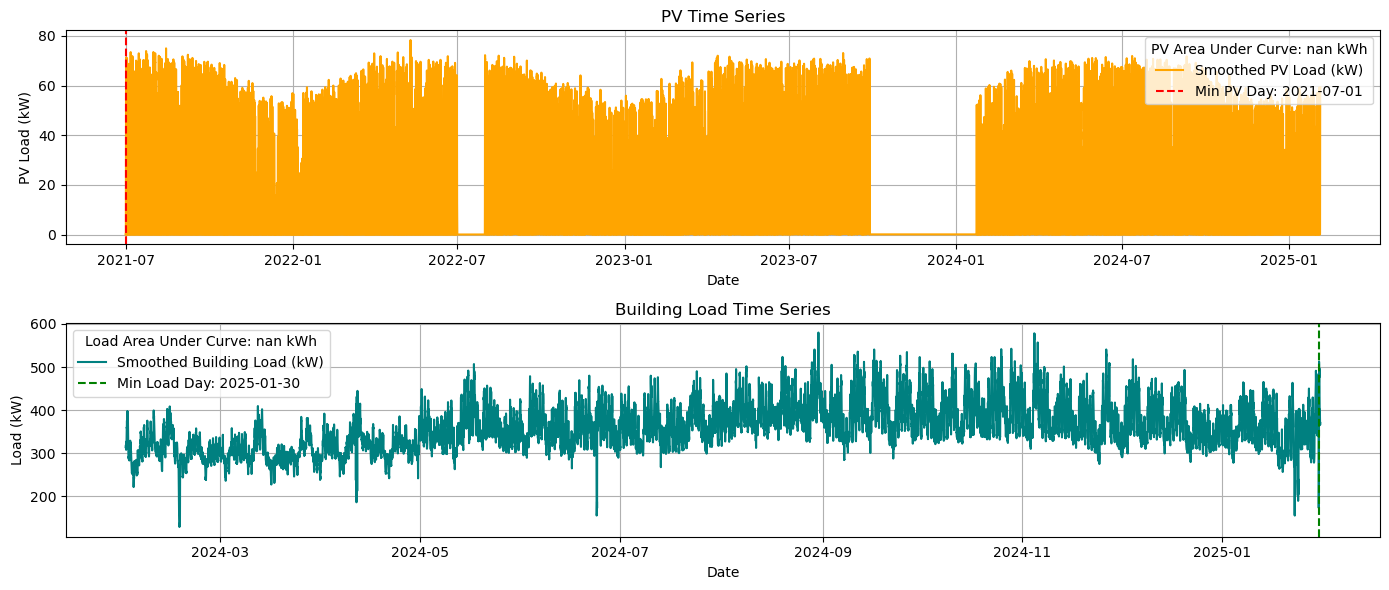

In [72]:
# Ensure that 'datetime' is in datetime format for both dataframes
load_df['datetime'] = pd.to_datetime(load_df['datetime'])
pv_df['datetime'] = pd.to_datetime(pv_df['datetime'])

# Rename columns for consistency
load_df = load_df.rename(columns={'mean': 'load_kw'})
pv_df = pv_df.rename(columns={'power_avg_kw': 'pv_kw'})

# Apply a rolling average to smooth out the zigzags (using window size of 5)
window_size = 5  # You can adjust this if needed
load_df['smoothed_load'] = load_df['load_kw'].rolling(window=window_size).mean()
pv_df['smoothed_pv'] = pv_df['pv_kw'].rolling(window=window_size).mean()

# Plotting the PV and Load time series before merge
plt.figure(figsize=(14, 6))

# Plot PV time series
plt.subplot(2, 1, 1)
plt.plot(pv_df['datetime'], pv_df['smoothed_pv'], label="Smoothed PV Load (kW)", color='orange')
plt.title("PV Time Series")
plt.xlabel("Date")
plt.ylabel("PV Load (kW)")
plt.grid(True)

# Plot Load time series
plt.subplot(2, 1, 2)
plt.plot(load_df['datetime'], load_df['smoothed_load'], label="Smoothed Building Load (kW)", color='teal')
plt.title("Building Load Time Series")
plt.xlabel("Date")
plt.ylabel("Load (kW)")
plt.grid(True)

# Highlight the minimum load day and minimum PV day
min_load_day = load_df['load_kw'].idxmin()
min_pv_day = pv_df['pv_kw'].idxmin()

# Plot vertical lines for minimum values
plt.subplot(2, 1, 1)  # PV plot
plt.axvline(x=pv_df.loc[min_pv_day, 'datetime'], color='red', linestyle='--', label=f"Min PV Day: {pv_df.loc[min_pv_day, 'datetime'].date()}")
plt.subplot(2, 1, 2)  # Load plot
plt.axvline(x=load_df.loc[min_load_day, 'datetime'], color='green', linestyle='--', label=f"Min Load Day: {load_df.loc[min_load_day, 'datetime'].date()}")

# Calculate the area under the curve (integral) for both PV and Load using the trapezoidal rule
# Convert datetime to timestamp (seconds) for numerical calculation
pv_timestamps = pv_df['datetime'].view('int64') // 10**9  # Convert to seconds
load_timestamps = load_df['datetime'].view('int64') // 10**9  # Convert to seconds

pv_area = np.trapz(pv_df['smoothed_pv'], pv_timestamps)  # Area under PV curve
load_area = np.trapz(load_df['smoothed_load'], load_timestamps)  # Area under Load curve

# Show the calculated areas in the title or labels
plt.subplot(2, 1, 1)
plt.legend(title=f"PV Area Under Curve: {pv_area:.2f} kWh")

plt.subplot(2, 1, 2)
plt.legend(title=f"Load Area Under Curve: {load_area:.2f} kWh")

plt.tight_layout()
plt.show()

## 📈 Step 3: Calculate Daily Energy Usage

To find the peak energy days, we calculate the **area under the power curve (kWh)** for each day.  
This is done by summing `power × time interval` across each day.

compute_daily_energy : do this for the net load to find the true daily energy demand.


In [57]:
def compute_daily_energy(df, column):
    #  datetime is datetime type because python wanna play w me...
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Sort values just in case
    df = df.sort_values(by='datetime')

    # Set datetime as index
    df = df.set_index('datetime')

    # Resample to daily and integrate using trapezoidal rule
    daily_energy = df[column].resample('D').apply(
        lambda y: (y.sum() * (15 / 60))  # assuming data is every 15 mins
    ).to_frame(name=f'daily_energy_kwh_{column}')

    # Reset index for plotting or analysis
    return daily_energy.reset_index()


In [ ]:
daily_net_energy = compute_daily_energy(merged_df, 'net_load_kw')

# Find the peak energy usage day
peak_day = daily_net_energy.loc[daily_net_energy[f'daily_energy_kwh_net_load_kw'].idxmax()]
print("🌞 Peak Net Load Day:")
print(peak_day)
#this is with pv yall...

🌞 Peak Net Load Day:
datetime                        2024-11-05 00:00:00
daily_energy_kwh_net_load_kw             10702.8105
Name: 278, dtype: object


## 📊 Step 4: Plot Daily Net Energy

Below is a line plot of daily net energy usage to visually identify demand trends and peak days.


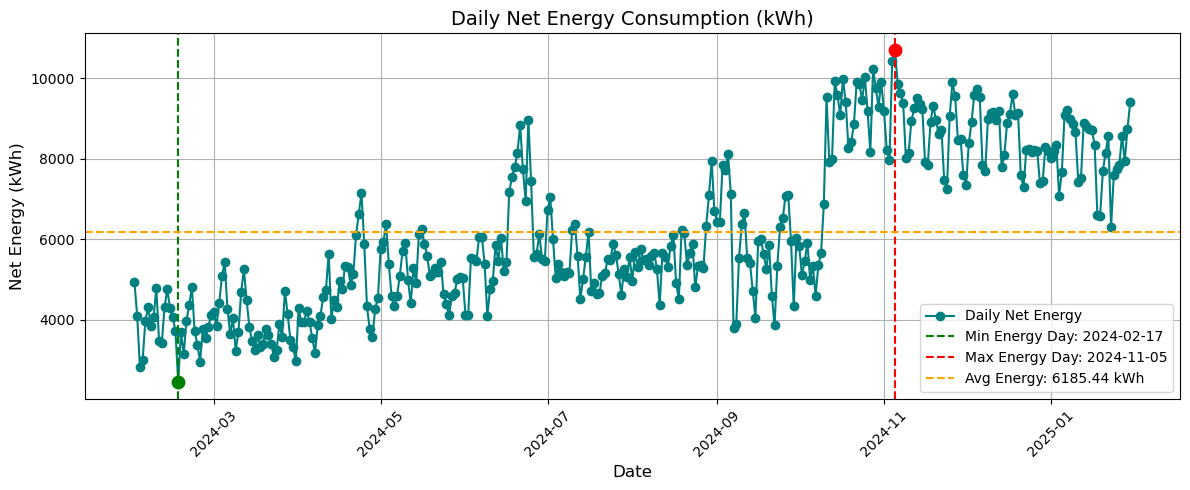

In [56]:
# Ensure that 'datetime' is in datetime format
daily_net_energy['datetime'] = pd.to_datetime(daily_net_energy['datetime'])

# Find the minimum, maximum, and average net energy days
min_net_energy_day = daily_net_energy['daily_energy_kwh_net_load_kw'].idxmin()
max_net_energy_day = daily_net_energy['daily_energy_kwh_net_load_kw'].idxmax()
avg_net_energy_value = daily_net_energy['daily_energy_kwh_net_load_kw'].mean()

# Get the datetime and values for the min and max points
min_net_energy_datetime = daily_net_energy.loc[min_net_energy_day, 'datetime']
max_net_energy_datetime = daily_net_energy.loc[max_net_energy_day, 'datetime']
min_net_energy_value = daily_net_energy.loc[min_net_energy_day, 'daily_energy_kwh_net_load_kw']
max_net_energy_value = daily_net_energy.loc[max_net_energy_day, 'daily_energy_kwh_net_load_kw']

# Plot setup
plt.figure(figsize=(12, 5))

# Plot the daily net energy line
plt.plot(
    daily_net_energy['datetime'], 
    daily_net_energy['daily_energy_kwh_net_load_kw'], 
    marker='o', 
    color='teal', 
    label='Daily Net Energy'
)

# Add vertical lines
plt.axvline(x=min_net_energy_datetime, color='green', linestyle='--', label=f"Min Energy Day: {min_net_energy_datetime.date()}")
plt.axvline(x=max_net_energy_datetime, color='red', linestyle='--', label=f"Max Energy Day: {max_net_energy_datetime.date()}")

# 💡 Add dots at min/max points to match vertical lines
plt.scatter(min_net_energy_datetime, min_net_energy_value, color='green', s=80, zorder=5)
plt.scatter(max_net_energy_datetime, max_net_energy_value, color='red', s=80, zorder=5)

# Add horizontal line for average energy
plt.axhline(y=avg_net_energy_value, color='orange', linestyle='--', label=f"Avg Energy: {avg_net_energy_value:.2f} kWh")

# Labels, legend, and pretties
plt.title("Daily Net Energy Consumption (kWh)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Net Energy (kWh)", fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the magic
plt.show()


### Analysis of Building Load: Min, Max, and Average Load Days

In this section, we analyze the building load data to identify key days:

1. **Minimum Load Day**: 
   - This is the day with the lowest total load. We calculate this by resampling the data to a daily frequency and summing the `load_kw` for each day. The day with the smallest sum represents the minimum load day.

2. **Maximum Load Day**:
   - This is the day with the highest total load. Similar to the minimum load day, we resample the data by day and sum the `load_kw`. The day with the largest sum represents the maximum load day.

3. **Average Load Day**:
   - The average load day is defined here as the midpoint between the minimum and maximum load days. This is a simple representation, but other methods could be used, such as taking the day closest to the overall mean load.

4. **Non-Zero Building Load Time Series**:
   - This time series graph displays only the periods where the building load was greater than zero. This allows us to focus on the actual periods when energy consumption was significant, filtering out any zero-load periods.

The plots include:
- **Daily Load Overview**: A line plot showing the total load for each day, with vertical lines indicating the minimum, maximum, and average load days.
- **Non-Zero Load Time Series**: A plot focusing on the periods where the building load was non-zero, providing a more granular view of energy usage during those times.

These visualizations help us understand the variation in energy consumption, identify periods of


## ✅ Conclusion

We successfully merged building load and PV generation data to calculate the net energy demand over time.  
By analyzing the area under the power curve (kWh), we identified the peak energy day for the building.  
This analysis provides essential insight for future battery sizing and load balancing strategies.
